In [1]:
import os, sys

recsys_cf = os.environ.get("RECSYS_STORY")
sys.path.append(recsys_cf)
os.chdir(recsys_cf)

from lib.tools import *

In [ ]:
recsys_cf = ''

In [2]:
from urllib.parse import urlparse

In [3]:
%matplotlib inline

In [4]:
@udf(stypes.StringType())
def get_url_path(url):
    try:
        url_parse = urlparse(url)
    except Exception as e:
        print(e)
        return None

    return url_parse.path

###### spark 

In [5]:
sp = spark(**SPARK_CONFIG)
hive = sp.sql

###### load_table 

In [6]:
visit = load_table(SBX_TEAM_DIGITCAMP, "tmp_visit_140621_200621", hive)

In [7]:
visit.show(3)

,cid,sbboluserid,sessionStartTime,hitTime,hitPageHostName,hitPagePath
0,665655226.1623617732,None,1623618000,0,lks.domclick.ru,/
1,719091194.1623617924,None,1623618000,0,osago.sberbank.ru,/
2,354588923.1623479990,None,1623618000,0,domclick.ru,/


In [8]:
visit.cache()

DataFrame[cid: string, sbboluserid: string, sessionStartTime: bigint, hitTime: bigint, hitPageHostName: string, hitPagePath: string]

In [9]:
visit.count()

686868777

In [10]:
visit_path = visit

In [11]:
visit_path.cache().count()

686868777

In [12]:
visit_path.show()

,cid,sbboluserid,sessionStartTime,hitTime,hitPageHostName,hitPagePath
0,665655226.1623617732,None,1623618000,0,lks.domclick.ru,/
1,719091194.1623617924,None,1623618000,0,osago.sberbank.ru,/
2,354588923.1623479990,None,1623618000,0,domclick.ru,/
3,1343171466.1585798623,None,1623618000,0,online.sberbank.ru,/
4,1558314699.1588027687,None,1623618000,0,sbermobile.ru,/
5,486355190.1623617593,None,1623618000,0,sberbusiness.live,/
6,1399304114.1623617836,None,1623618000,0,sberprime.sber.ru,/
7,240973433.1623617990,None,1623618000,0,promo.sber.ru,/12june
8,2136630026.1604649743,None,1623618000,0,promo.sber.ru,/12june/
9,1419604719.1623617782,None,1623618000,0,promo.sber.ru,/12june/


###### create stats 

Посчитаем статистику по главной странице сбербанк.ру

In [14]:
class PipelinelMainPageTimeStatsSdf():
    
    
    def __init__(self, spark, visit):
        self.hive = spark.sql
        self.visit = visit
        
        
        
    def run(self):
        
        
        return self.sberbank_ru_page_stat_time_sdf(self.visit)
    
    
    @staticmethod
    @udf(stypes.StringType())
    def get_url_path(url):
        try:
            url_parse = urlparse(url)
        except Exception as e:
            print(e)
            return None

        return url_parse.path
    
    
    @staticmethod
    @udf(stypes.IntegerType())
    def get_stage(hitPagePath, lastPagePath, nextPagePath):
    #     """Stage: 
    #     0 - not target
    #         1 - last action before target
    #             2 - first action on target
    #             3 - intermediate page on target
    #             4 - last action on target
    #         5 - first action after target
    #     """
        
        
#         targetPagePath = f.lit(self.pagepath)
        targetPagePath = "/ru/s_m_business"
        if hitPagePath == targetPagePath:
            
            # if "\main" - first/last page in session => set it as the last/first action before target
            if lastPagePath == "FIRST_HIT_IN_SESSION":
                return 1
            elif nextPagePath == "LAST_HIT_IN_SESSION":
                return 5
            
            if lastPagePath == targetPagePath and nextPagePath == targetPagePath:
                return 3
            elif nextPagePath == targetPagePath:
                return 2
            elif lastPagePath == targetPagePath:
                return 4
            else: # one element in target-list
                return 2
        else:
            # if other page between target => set it as an intermediate page on target
            if lastPagePath == targetPagePath and nextPagePath == targetPagePath: 
                return 3
            if nextPagePath == targetPagePath:
                return 1
            elif lastPagePath == targetPagePath:
                return 5
            else:
                return 0  
            
            
            
            
    def sberbank_ru_page_stat_time_sdf(self, visit):
        window = Window.partitionBy("cid", "sessionStartTime") \
                .orderBy("hitTime", "hitPagePath")

        visit_last_next = visit.withColumn("lastPagePath", 
                                           f.lag("hitPagePath", default="FIRST_HIT_IN_SESSION").over(window)) \
                               .withColumn("nextPagePath", 
                                           f.lead("hitPagePath", default="LAST_HIT_IN_SESSION").over(window)) \
                               .orderBy("cid", "sessionStartTime", "hitTime",  "hitPagePath")
        
        visit_last_next = visit_last_next.withColumn("hitPagePath", self.get_url_path(f.col("hitPagePath")))\
                                         .filter(f.col("hitPagePath") != "/" )
            
        visit_stage = visit_last_next.withColumn("stage", 
                                    self.get_stage(f.col("hitPagePath"),
                                                   f.col("lastPagePath"),
                                                   f.col("nextPagePath"))) \
                        .select("cid", "sessionStartTime", "hitTime", "hitPagePath", "stage")
            
        begin_stage, end_stage = 1, 5

        visit_begin_end = visit_stage.filter("stage in ({}, {})".format(begin_stage, end_stage)) \
                                     .withColumn("prevHitTime", 
                                                 f.when(f.col("stage") == end_stage, 
                                                 f.lag("hitTime").over(window)).otherwise(0))
            
        visit_duration = visit_begin_end.withColumn("hitDuration", 
                                                    f.when(f.col("stage") == 5,
                                                    f.col("hitTime") - f.col("prevHitTime")).otherwise(0))\
                                        .filter("hitDuration <> 0")\
                                        .select("cid", "sessionStartTime", "hitTime", "hitDuration")
                
        visit_session_agg = visit_duration.groupBy("cid", "sessionStartTime")\
                                          .agg(f.count("hitDuration").alias("countMainVisits"), 
                                               f.sum("hitDuration").alias("sumMainTime"),
                                               f.first("hitDuration").alias("firstMainTime"))
            
        visit_user_agg = visit_session_agg.groupBy("cid") \
                                          .agg(f.avg("countMainVisits").alias("avgCountMainVisits"), 
                                               (f.avg("sumMainTime") / 1000).alias("avgMainTimeSec"), 
                                               (f.avg("firstMainTime") / 1000).alias("avgFirstMainTimeSec"))
        
        return visit_user_agg

In [15]:
smb = PipelinelMainPageTimeStatsSdf(sp, visit_path)

In [16]:
smb_stat = smb.run().cache()

In [17]:
smb_stat.count()

105434

In [18]:
smb_stat.show()

,cid,avgCountMainVisits,avgMainTimeSec,avgFirstMainTimeSec
0,1435814010.1607700948,2.000000,41.289000,7.560000
1,690315336.1616408376,1.111111,146.078444,144.027889
2,122101052.1623960031,1.000000,35.316000,35.316000
3,882395555.1620742390,1.125000,354.460500,344.653250
4,964058065.1620661221,1.000000,130.358500,130.358500
5,617146237.1554707481,2.000000,53.574667,25.074000
6,1246118895.1623997466,2.000000,24.657000,14.941000
7,529293708.1622009508,1.800000,23.572600,17.186400
8,1608987946.1623563150,2.000000,33.231000,24.568000
9,231794248.1609869812,1.333333,55.600667,49.443667


теперь получим статистику по посещением главной страницы сббола

In [19]:
class PipelineSbbolMainPageTimeStatsSdf():
    
    
    def __init__(self, spark, visit):
        self.hive = spark.sql
        self.visit = visit
        
        
        
    def run(self):
        
        
        return self.sbbol_page_stat_time_sdf(self.visit)
    
    
    @staticmethod
    @udf(stypes.StringType())
    def get_url_path(url):
        try:
            url_parse = urlparse(url)
        except Exception as e:
            print(e)
            return None

        return url_parse.path
    
    
    @staticmethod
    @udf(stypes.IntegerType())
    def get_stage(hitPagePath, lastPagePath, nextPagePath):
    #     """Stage: 
    #     0 - not target
    #         1 - last action before target
    #             2 - first action on target
    #             3 - intermediate page on target
    #             4 - last action on target
    #         5 - first action after target
    #     """
        
        
#         targetPagePath = f.lit(self.pagepath)
        targetPagePath = "/main"
        if hitPagePath == targetPagePath:
            
            # if "\main" - first/last page in session => set it as the last/first action before target
            if lastPagePath == "FIRST_HIT_IN_SESSION":
                return 1
            elif nextPagePath == "LAST_HIT_IN_SESSION":
                return 5
            
            if lastPagePath == targetPagePath and nextPagePath == targetPagePath:
                return 3
            elif nextPagePath == targetPagePath:
                return 2
            elif lastPagePath == targetPagePath:
                return 4
            else: # one element in target-list
                return 2
        else:
            # if other page between target => set it as an intermediate page on target
            if lastPagePath == targetPagePath and nextPagePath == targetPagePath: 
                return 3
            if nextPagePath == targetPagePath:
                return 1
            elif lastPagePath == targetPagePath:
                return 5
            else:
                return 0  
            
            
            
            
    def sbbol_page_stat_time_sdf(self, visit):
        window = Window.partitionBy("sbboluserid", "sessionStartTime") \
                .orderBy("hitTime", "hitPagePath")

        visit_last_next = visit.filter("sbboluserid is not Null AND hitPageHostName = 'sbi.sberbank.ru'")\
                               .withColumn("lastPagePath", 
                                           f.lag("hitPagePath", default="FIRST_HIT_IN_SESSION").over(window)) \
                               .withColumn("nextPagePath", 
                                           f.lead("hitPagePath", default="LAST_HIT_IN_SESSION").over(window)) \
                               .orderBy("sbboluserid", "sessionStartTime", "hitTime",  "hitPagePath").cache()
        
        visit_last_next = visit_last_next.withColumn("hitPagePath", self.get_url_path(f.col("hitPagePath")))\
                                         .filter(f.col("hitPagePath") != "/" )
            
        visit_stage = visit_last_next.withColumn("stage", 
                                    self.get_stage(f.col("hitPagePath"),
                                                   f.col("lastPagePath"),
                                                   f.col("nextPagePath"))) \
                        .select("sbboluserid", "sessionStartTime", "hitTime", "hitPagePath", "stage").cache()
            
        begin_stage, end_stage = 1, 5

        visit_begin_end = visit_stage.filter("stage in ({}, {})".format(begin_stage, end_stage)) \
                                     .withColumn("prevHitTime", 
                                                 f.when(f.col("stage") == end_stage, 
                                                 f.lag("hitTime").over(window)).otherwise(0)).cache()
            
        visit_duration = visit_begin_end.withColumn("hitDuration", 
                                                    f.when(f.col("stage") == 5,
                                                    f.col("hitTime") - f.col("prevHitTime")).otherwise(0))\
                                        .filter("hitDuration <> 0")\
                                        .select("sbboluserid", "sessionStartTime", "hitTime", "hitDuration").cache()
                
        visit_session_agg = visit_duration.groupBy("sbboluserid", "sessionStartTime")\
                                          .agg(f.count("hitDuration").alias("countMainVisits"), 
                                               f.sum("hitDuration").alias("sumMainTime"),
                                               f.first("hitDuration").alias("firstMainTime")).cache()
            
        visit_user_agg = visit_session_agg.groupBy("sbboluserid") \
                                          .agg(f.avg("countMainVisits").alias("avgCountMainVisits"), 
                                               (f.avg("sumMainTime") / 1000).alias("avgMainTimeSec"), 
                                               (f.avg("firstMainTime") / 1000).alias("avgFirstMainTimeSec"))
        
        return visit_user_agg

In [20]:
sbbol_main = PipelineSbbolMainPageTimeStatsSdf(sp, visit_path)

In [21]:
sbbol_main_stats = sbbol_main.run().cache()

### Статистика посещений главных страниц 

**avgCountMainVisits** - среднее количество посещений данным юзером главной страницы за сессию 

**avgMainTimeSec** - среднее время нахождения юзера на главной странице за сессию (время берется суммарно за сессию, что может не совсем корректно отражать суть задачи, ткт юзер за одну сессию мог перезаходить на главную страницу 100500 раз, при этом каждое посещение длилось по 1 секунде)

**avgFirstMainTimeSec** - самое первое время нахождения на главной странице юзером

Таблица статистики посещений главной страницы сббола

In [22]:
sbbol_main_stats.show()

,sbboluserid,avgCountMainVisits,avgMainTimeSec,avgFirstMainTimeSec
0,36b61e27-79f3-4088-9119-a19937897938,1.50,1366.824000,496.302500
1,3c25f076-1c3a-fc84-e054-90e2ba85d0c8,1.20,100.011000,96.791400
2,3c25f0ab-1538-1d5b-e054-90e2ba9a7f6c,1.75,363.333500,64.661250
3,40ead067-58c0-443d-999e-8cb1f736c83b,1.80,75.634200,61.787800
4,642a7e65-1ffb-4790-a0e7-81902398b7d6,2.00,144.831857,76.132000
5,6451d6db-2e16-4f86-8fce-af4192b0a5b1,1.00,15.218400,15.218400
6,6f819a0f-bb44-4172-9e7f-95d641a2a9a6,2.00,10.163000,6.983000
7,7ee7f517-ea97-41bd-96fc-9019a8e1198d,1.00,11.640000,11.640000
8,8105da31-7b71-4daa-96bd-6f16045eb549,2.00,567.423000,466.039857
9,8cca23cc-5798-466e-92d9-21285f1d4c06,1.50,172.835000,71.767625


Таблица статистики посещений главной страницы сбербанк.ру

In [23]:
smb_stat.show()

,cid,avgCountMainVisits,avgMainTimeSec,avgFirstMainTimeSec
0,1435814010.1607700948,2.000000,41.289000,7.560000
1,690315336.1616408376,1.111111,146.078444,144.027889
2,122101052.1623960031,1.000000,35.316000,35.316000
3,882395555.1620742390,1.125000,354.460500,344.653250
4,964058065.1620661221,1.000000,130.358500,130.358500
5,617146237.1554707481,2.000000,53.574667,25.074000
6,1246118895.1623997466,2.000000,24.657000,14.941000
7,529293708.1622009508,1.800000,23.572600,17.186400
8,1608987946.1623563150,2.000000,33.231000,24.568000
9,231794248.1609869812,1.333333,55.600667,49.443667


In [24]:
print("Юзеров СББОЛа за неделю, посещавших главную страницу:", sbbol_main_stats.count())
print("СИДов СБЕРБАНК.РУ за неделю, посещавших главную страницу s_m_business:", smb_stat.count())

Юзеров СББОЛа за неделю, посещавших главную страницу: 746611
СИДов СБЕРБАНК.РУ за неделю, посещавших главную страницу s_m_business: 105434


### s_m_business 

In [25]:
smb_stat.describe("avgCountMainVisits", "avgMainTimeSec", "avgFirstMainTimeSec").show()

,summary,avgCountMainVisits,avgMainTimeSec,avgFirstMainTimeSec
0,count,105434,105434,105434
1,mean,1.411204763663794,126.48462300106837,83.48213449749232
2,stddev,0.6500093692551605,233.3803899776562,168.45272455410682
3,min,1.0,0.001,0.001
4,max,15.0,4191.07,3216.152


In [26]:
smb_stat.filter("avgCountMainVisits < 6 AND avgMainTimeSec < 1000")\
                .describe("avgCountMainVisits", "avgMainTimeSec", "avgFirstMainTimeSec").show()

,summary,avgCountMainVisits,avgMainTimeSec,avgFirstMainTimeSec
0,count,103586,103586,103586
1,mean,1.3933411763299854,103.81794244380347,71.50431234019351
2,stddev,0.5936243424488493,148.3989809808984,111.92231696164329
3,min,1.0,0.001,0.001
4,max,5.5,999.603,999.603


In [27]:
%%time
smb_stat_pdf = smb_stat.toPandas()

CPU times: user 663 ms, sys: 87.1 ms, total: 750 ms
Wall time: 1.11 s


In [28]:
sbbol_main_stats.describe("avgCountMainVisits", "avgMainTimeSec", "avgFirstMainTimeSec").show()

,summary,avgCountMainVisits,avgMainTimeSec,avgFirstMainTimeSec
0,count,746611,746611,746611
1,mean,1.4502106719461094,164.7878274749845,109.79495163621986
2,stddev,1.1073638780751898,389.8736263461707,266.77979052420415
3,min,1.0,0.001,0.001
4,max,84.5,33878.838,33878.838


In [29]:
sbbol_main_stats.filter("avgCountMainVisits < 25 AND avgMainTimeSec < 1000")\
                .describe("avgCountMainVisits", "avgMainTimeSec", "avgFirstMainTimeSec").show()

,summary,avgCountMainVisits,avgMainTimeSec,avgFirstMainTimeSec
0,count,724104,724104,724104
1,mean,1.4100570972983828,115.196144518077,83.15412623693821
2,stddev,0.9134039347715327,175.50855326313717,139.13686423163608
3,min,1.0,0.001,0.001
4,max,24.75,999.98025,999.966


In [30]:
%%time
sbbol_main_stats_pdf = sbbol_main_stats.toPandas()

CPU times: user 4.02 s, sys: 504 ms, total: 4.52 s
Wall time: 5 s


###### Сравнение среднего количества посещений главной страницы за сессию 

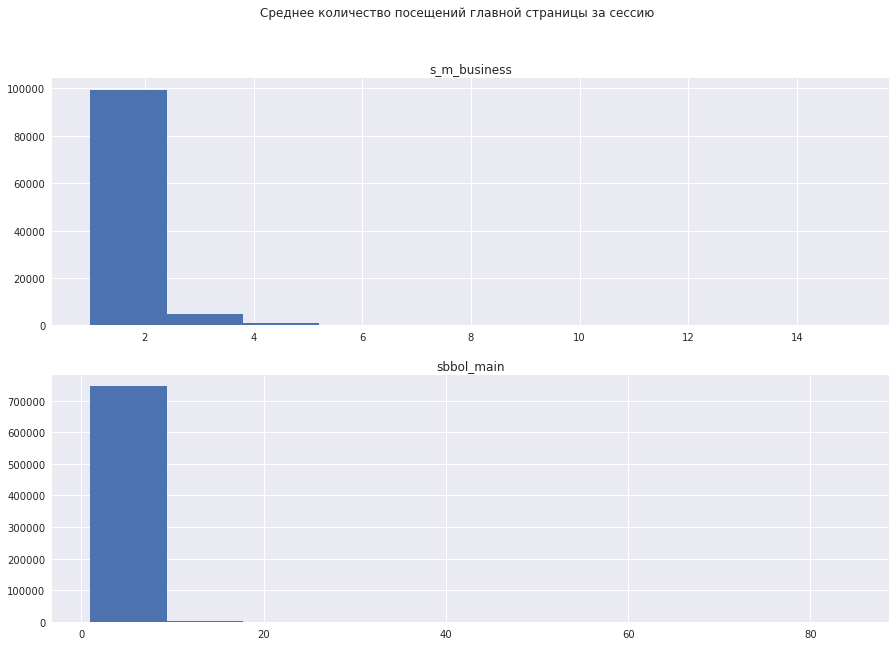

In [31]:
fig, axs = plt.subplots(2)
# plt.figure(figsize=(18,8))
fig.set_size_inches(15, 10)
fig.suptitle("Среднее количество посещений главной страницы за сессию")
axs[0].hist(smb_stat_pdf.avgCountMainVisits)
axs[0].set_title("s_m_business")

axs[1].hist(sbbol_main_stats_pdf.avgCountMainVisits)
axs[1].set_title("sbbol_main")
plt.show()

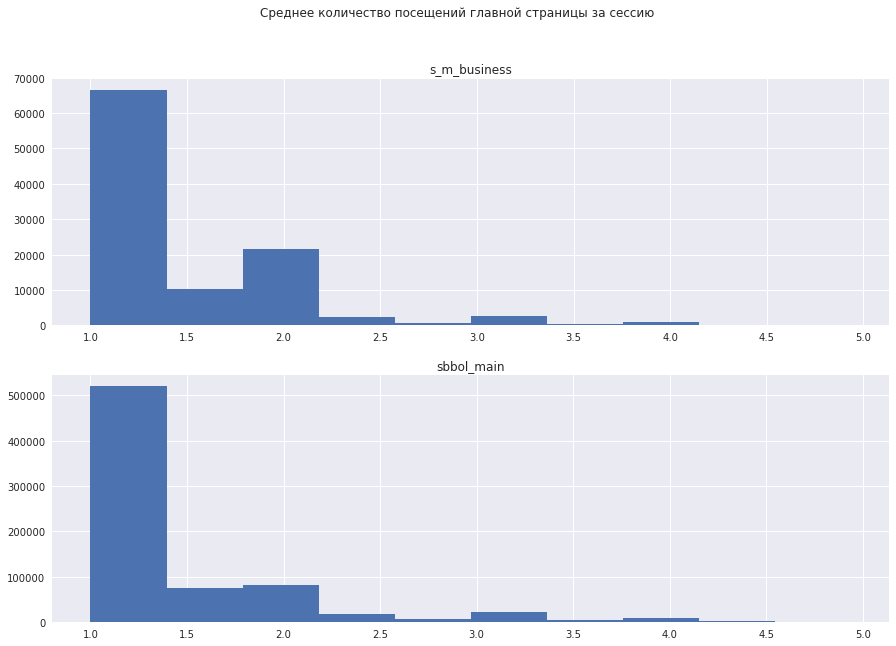

In [32]:
fig, axs = plt.subplots(2)
# plt.figure(figsize=(18,8))
fig.set_size_inches(15, 10)
fig.suptitle("Среднее количество посещений главной страницы за сессию")
axs[0].hist(smb_stat_pdf[smb_stat_pdf.avgCountMainVisits < 5].avgCountMainVisits)
axs[0].set_title("s_m_business")

axs[1].hist(sbbol_main_stats_pdf[sbbol_main_stats_pdf.avgCountMainVisits < 5].avgCountMainVisits)
axs[1].set_title("sbbol_main")
plt.show()

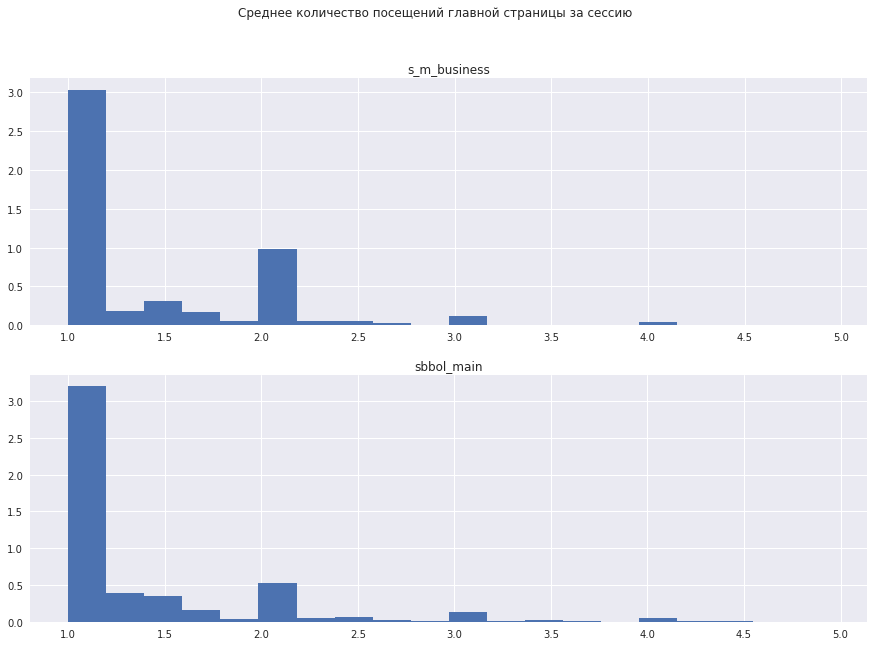

In [33]:
fig, axs = plt.subplots(2)
# plt.figure(figsize=(18,8))
fig.set_size_inches(15, 10)
fig.suptitle("Среднее количество посещений главной страницы за сессию")
axs[0].hist(smb_stat_pdf[smb_stat_pdf.avgCountMainVisits < 5].avgCountMainVisits, normed=True, bins=20)
axs[0].set_title("s_m_business")

axs[1].hist(sbbol_main_stats_pdf[sbbol_main_stats_pdf.avgCountMainVisits < 5].avgCountMainVisits, normed=True, bins=20)
axs[1].set_title("sbbol_main")
plt.show()

Таким образом видим, что гистограммы сильно похожи, то есть по частоте посещений целевых страниц в рамках одной сессии юзеры ведут себя очень похоже

###### Сравнение времени нахождения на главной странице 

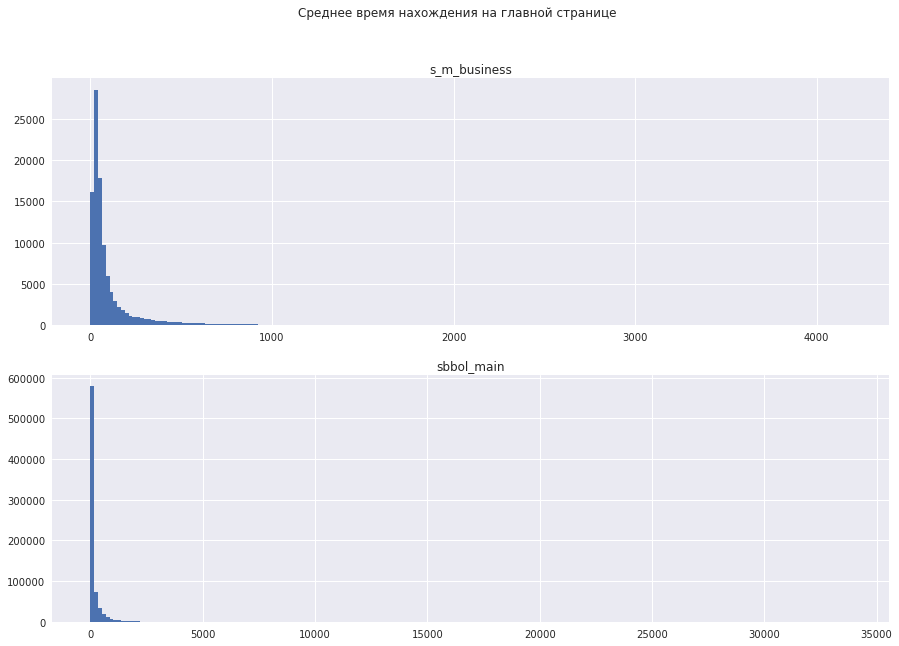

In [34]:
fig, axs = plt.subplots(2)
# plt.figure(figsize=(18,8))
fig.set_size_inches(15, 10)
fig.suptitle("Среднее время нахождения на главной странице")
axs[0].hist(smb_stat_pdf.avgMainTimeSec, bins=200)
axs[0].set_title("s_m_business")

axs[1].hist(sbbol_main_stats_pdf.avgMainTimeSec, bins=200)
axs[1].set_title("sbbol_main")
plt.show()

NameError: name 'max_cnt' is not defined

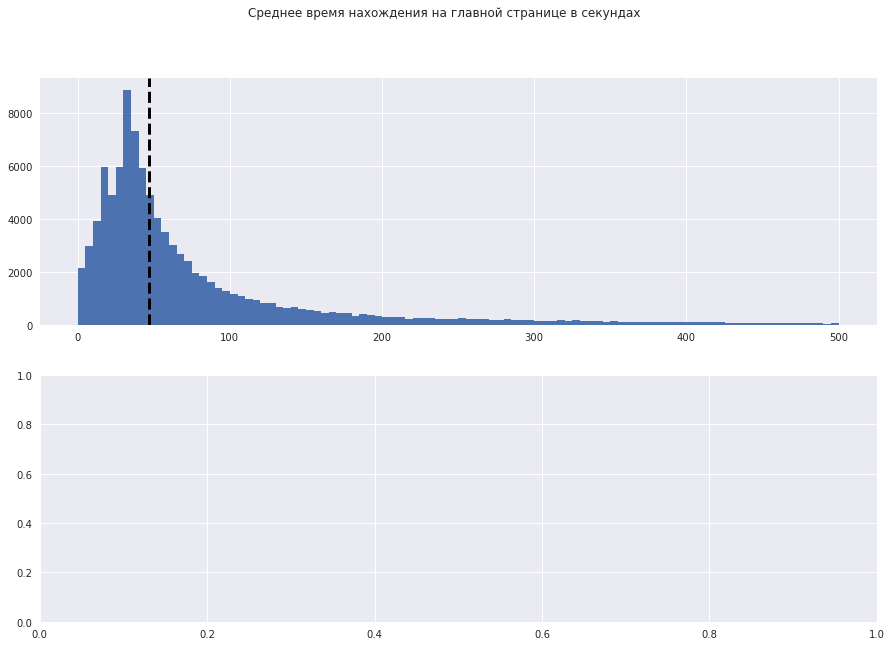

In [35]:
mean_sbbol = np.mean(sbbol_main_stats_pdf[sbbol_main_stats_pdf.avgMainTimeSec < 500].avgMainTimeSec.values)
median_sbbol = np.median(sbbol_main_stats_pdf[sbbol_main_stats_pdf.avgMainTimeSec < 500].avgMainTimeSec.values)

mean_smb = np.mean(smb_stat_pdf[smb_stat_pdf.avgMainTimeSec < 500].avgMainTimeSec.values)
median_smb = np.median(smb_stat_pdf[smb_stat_pdf.avgMainTimeSec < 500].avgMainTimeSec.values)


fig, axs = plt.subplots(2)
# plt.figure(figsize=(18,8))
fig.set_size_inches(15, 10)
fig.suptitle("Среднее время нахождения на главной странице в секундах")
axs[0].hist(smb_stat_pdf[smb_stat_pdf.avgMainTimeSec < 500].avgMainTimeSec, bins=100, normed=False)
axs[0].axvline(median_smb, **{"color": "k", "linewidth": 3, "linestyle": "--", 
                                    "label": "{}: {}".format("median_smb: ", median_smb)})
axs[0].axvline(mean_smb, 0, max_cnt, **{"color": "b", "linewidth": 3, 
                                  "label": "{}: {}".format("mean_smb: ", mean_smb)})

axs[0].set_title("s_m_business")
axs[0].legend()


axs[1].hist(sbbol_main_stats_pdf[sbbol_main_stats_pdf.avgMainTimeSec < 500].avgMainTimeSec, bins=100, normed=False)
axs[1].axvline(median_sbbol, **{"color": "k", "linewidth": 3, "linestyle": "--", 
                                    "label": "{}: {}".format("median_sbbol: ", median_sbbol)})
axs[1].axvline(mean_sbbol, 0, max_cnt, **{"color": "b", "linewidth": 3, 
                                  "label": "{}: {}".format("mean_sbbol: ", round(mean_sbbol, 3))})
axs[1].set_title("sbbol_main")
axs[1].legend()


plt.show()

In [ ]:
mean_sbbol = np.mean(sbbol_main_stats_pdf[sbbol_main_stats_pdf.avgMainTimeSec < 200].avgMainTimeSec.values)
median_sbbol = np.median(sbbol_main_stats_pdf[sbbol_main_stats_pdf.avgMainTimeSec < 200].avgMainTimeSec.values)

mean_smb = np.mean(smb_stat_pdf[smb_stat_pdf.avgMainTimeSec < 200].avgMainTimeSec.values)
median_smb = np.median(smb_stat_pdf[smb_stat_pdf.avgMainTimeSec < 200].avgMainTimeSec.values)


fig, axs = plt.subplots(2)
# plt.figure(figsize=(18,8))
fig.set_size_inches(15, 10)
fig.suptitle("Среднее время нахождения на главной странице в секундах")
axs[0].hist(smb_stat_pdf[smb_stat_pdf.avgMainTimeSec < 200].avgMainTimeSec, bins=200, normed=False)
axs[0].axvline(median_smb, **{"color": "k", "linewidth": 3, "linestyle": "--", 
                                    "label": "{}: {}".format("median_smb: ", median_smb)})
axs[0].axvline(mean_smb, 0, max_cnt, **{"color": "b", "linewidth": 3, 
                                  "label": "{}: {}".format("mean_smb: ", mean_smb)})

axs[0].set_title("s_m_business")
axs[0].legend()


axs[1].hist(sbbol_main_stats_pdf[sbbol_main_stats_pdf.avgMainTimeSec < 200].avgMainTimeSec, bins=200, normed=False)
axs[1].axvline(median_sbbol, **{"color": "k", "linewidth": 3, "linestyle": "--", 
                                    "label": "{}: {}".format("median_sbbol: ", median_sbbol)})
axs[1].axvline(mean_sbbol, 0, max_cnt, **{"color": "b", "linewidth": 3, 
                                  "label": "{}: {}".format("mean_sbbol: ", round(mean_sbbol, 3))})
axs[1].set_title("sbbol_main")
axs[1].legend()


plt.show()

Таким образом видим, что время посещения главной страницы сббола сильнее прижато к 0, что говорит о том, что в среднем юзеры проводят на ней меньше времени. Но количество юзеров, которые посещают главною страницу сббола сильно превозходит количество юзеров, посещающих см_бизнес, скорее всего это свидетельствует о необходимости заходить на главную страницу в сбболе.

In [36]:
import pickle
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm, mode

sns.set(rc={"figure.figsize": (14, 10)})
sns.set_style("whitegrid", {'axes.grid': False})
np.random.seed(0)

In [37]:
resdf = sbbol_main_stats_pdf[sbbol_main_stats_pdf.avgMainTimeSec < 1000]

In [38]:
# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(resdf["avgMainTimeSec"].min(), resdf["avgMainTimeSec"].max(), 100)
resdf.loc[:,'prob_bin'] = np.digitize(resdf["avgMainTimeSec"], bins)
resdf.loc[:,'mean_CTR_bin'] = resdf['prob_bin'].replace(dict(zip(range(len(bins)), bins)))
# resdf.head()

In [39]:
_mean = np.mean(resdf["avgMainTimeSec"].values)
_median = np.median(resdf["avgMainTimeSec"].values)
_mode = mode(resdf["mean_CTR_bin"].values, axis = None).mode[0]
max_cnt = mode(resdf["mean_CTR_bin"].values, axis = None).count[0] 

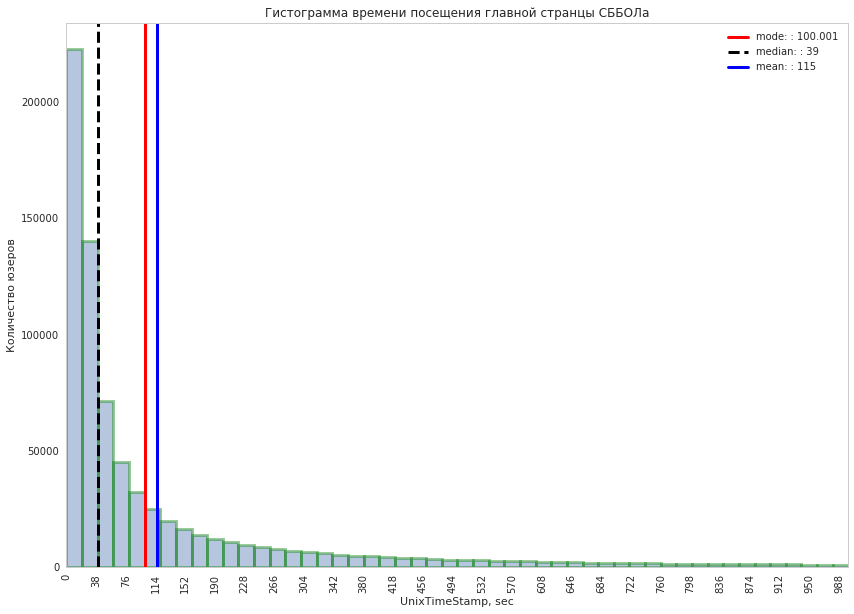

In [40]:
# fig = plt.figure(figsize=(9,5))
ystep = 300
nbins = 50
step = (int(resdf["avgMainTimeSec"].max()) - int(resdf["avgMainTimeSec"].min()))//nbins

ax = plt.axes()
ax.set_xlim(int(resdf["avgMainTimeSec"].min()), int(resdf["avgMainTimeSec"].max()))
ax.set_xticks(range(int(resdf["avgMainTimeSec"].min()), int(resdf["avgMainTimeSec"].max())+1,step*2))
title = 'Гистограмма времени посещения главной странцы СББОЛа'

g = sns.distplot(resdf["avgMainTimeSec"], 
             axlabel='UnixTimeStamp, sec',
             ax=ax,
             bins=nbins,
             hist=True,
             norm_hist=False,
             kde=False,
             kde_kws={'color': 'r', 'lw': 3, 'label': 'KDE'},
             hist_kws={"edgecolor":"g", "linewidth": 3}
            )
# g.set_xticklabels(rotation=90)
plt.axvline(_mode, 0, max_cnt, **{"color": "r", "linewidth": 3, "linestyle": "-", 
                                  "label": "{}: {}".format("mode: ", _mode)})
plt.axvline(_median, 0, max_cnt, **{"color": "k", "linewidth": 3, "linestyle": "--", 
                                    "label": "{}: {}".format("median: ", int(_median))})
plt.axvline(_mean, 0, max_cnt, **{"color": "b", "linewidth": 3, 
                                  "label": "{}: {}".format("mean: ", int(_mean))})
plt.title(title)
plt.xticks(rotation=90)
# plt.yticks(range(0,int(np.round(g.get_ylim()[1])),50))
plt.ylabel("Количество юзеров")
plt.legend(loc="upper right")
plt.show()

In [41]:
resdf = smb_stat_pdf[smb_stat_pdf.avgMainTimeSec < 1000]

In [42]:
# binning the dataframe, so we can see success rates for bins of probability
bins = np.arange(resdf["avgMainTimeSec"].min(), resdf["avgMainTimeSec"].max(), 100)
resdf.loc[:,'prob_bin'] = np.digitize(resdf["avgMainTimeSec"], bins)
resdf.loc[:,'mean_CTR_bin'] = resdf['prob_bin'].replace(dict(zip(range(len(bins)), bins)))
# resdf.head()

In [43]:
_mean = np.mean(resdf["avgMainTimeSec"].values)
_median = np.median(resdf["avgMainTimeSec"].values)
_mode = mode(resdf["mean_CTR_bin"].values, axis = None).mode[0]
max_cnt = mode(resdf["mean_CTR_bin"].values, axis = None).count[0] 

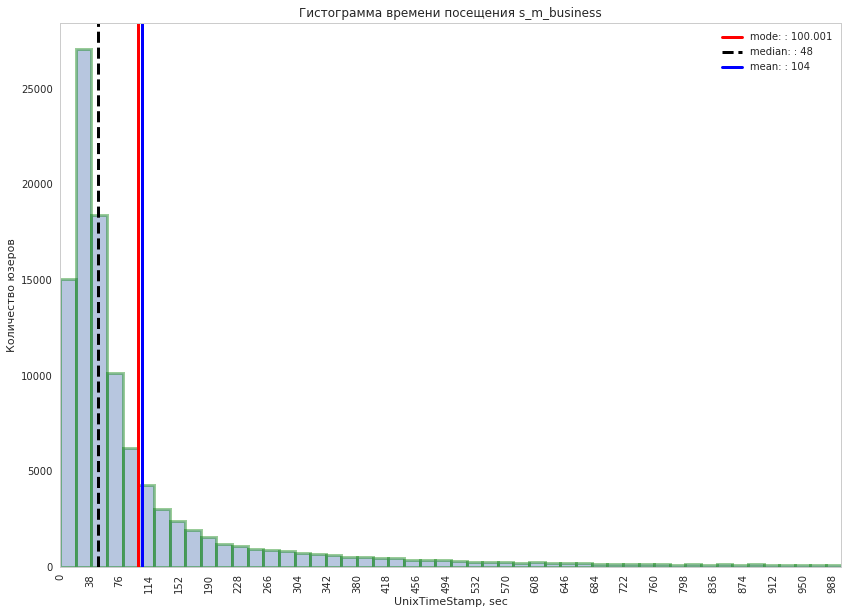

In [44]:
# fig = plt.figure(figsize=(9,5))
ystep = 300
nbins = 50
step = (int(resdf["avgMainTimeSec"].max()) - int(resdf["avgMainTimeSec"].min()))//nbins

ax = plt.axes()
ax.set_xlim(int(resdf["avgMainTimeSec"].min()), int(resdf["avgMainTimeSec"].max()))
ax.set_xticks(range(int(resdf["avgMainTimeSec"].min()), int(resdf["avgMainTimeSec"].max())+1,step*2))
title = 'Гистограмма времени посещения s_m_business'

g = sns.distplot(resdf["avgMainTimeSec"], 
             axlabel='UnixTimeStamp, sec',
             ax=ax,
             bins=nbins,
             hist=True,
             norm_hist=False,
             kde=False,
             kde_kws={'color': 'r', 'lw': 3, 'label': 'KDE'},
             hist_kws={"edgecolor":"g", "linewidth": 3}
            )
# g.set_xticklabels(rotation=90)
plt.axvline(_mode, 0, max_cnt, **{"color": "r", "linewidth": 3, "linestyle": "-", 
                                  "label": "{}: {}".format("mode: ", _mode)})
plt.axvline(_median, 0, max_cnt, **{"color": "k", "linewidth": 3, "linestyle": "--", 
                                    "label": "{}: {}".format("median: ", int(_median))})
plt.axvline(_mean, 0, max_cnt, **{"color": "b", "linewidth": 3, 
                                  "label": "{}: {}".format("mean: ", int(_mean))})
plt.title(title)
plt.xticks(rotation=90)
# plt.yticks(range(0,int(np.round(g.get_ylim()[1])),50))
plt.ylabel("Количество юзеров")
plt.legend(loc="upper right")
plt.show()

In [ ]:
class PipelinePageTimeStatsSdf():
    
    
    def __init__(self, spark, visit, sbbol=True, targetPagePath="/main"):
        self.hive = spark.sql
        self.visit = visit
        self.sbbol = sbbol
        self.targetPagePath = targetPagePath
        
        
        
    def run(self):
        if self.sbbol == True:
            return self.sbbol_page_stat_time_sdf(self.visit)
        else:
            return self.sberbank_ru_page_stat_time_sdf(self.visit)
    
    
    @staticmethod
    @udf(stypes.StringType())
    def get_url_path(url):
        try:
            url_parse = urlparse(url)
        except Exception as e:
            print(e)
            return None

        return url_parse.path
    
    
    @staticmethod
    @udf(stypes.IntegerType())
    def get_stage(hitPagePath, lastPagePath, nextPagePath):
    #     """Stage: 
    #     0 - not target
    #         1 - last action before target
    #             2 - first action on target
    #             3 - intermediate page on target
    #             4 - last action on target
    #         5 - first action after target
    #     """
        
        targetPagePath = self.targetPagePath
        
        if hitPagePath == targetPagePath:
            
            # if "\main" - first/last page in session => set it as the last/first action before target
            if lastPagePath == "FIRST_HIT_IN_SESSION":
                return 1
            elif nextPagePath == "LAST_HIT_IN_SESSION":
                return 5
            
            if lastPagePath == targetPagePath and nextPagePath == targetPagePath:
                return 3
            elif nextPagePath == targetPagePath:
                return 2
            elif lastPagePath == targetPagePath:
                return 4
            else: # one element in target-list
                return 2
        else:
            # if other page between target => set it as an intermediate page on target
            if lastPagePath == targetPagePath and nextPagePath == targetPagePath: 
                return 3
            if nextPagePath == targetPagePath:
                return 1
            elif lastPagePath == targetPagePath:
                return 5
            else:
                return 0  
            
            
            
            
    def sbbol_page_stat_time_sdf(self, visit):
        window = Window.partitionBy("sbboluserid", "sessionStartTime") \
                .orderBy("hitTime", "hitPagePath")

        visit_last_next = visit.filter("sbboluserid is not Null")\
                               .withColumn("lastPagePath", 
                                           f.lag("hitPagePath", default="FIRST_HIT_IN_SESSION").over(window)) \
                               .withColumn("nextPagePath", 
                                           f.lead("hitPagePath", default="LAST_HIT_IN_SESSION").over(window)) \
                               .orderBy("sbboluserid", "sessionStartTime", "hitTime",  "hitPagePath")
        
        visit_last_next = visit_last_next.withColumn("hitPagePath", self.get_url_path(f.col("hitPagePath")))\
                                         .filter(f.col("hitPagePath") != "/" )
            
        visit_stage = visit_last_next.withColumn("stage", 
                                    self.get_stage(f.col("hitPagePath"),
                                                   f.col("lastPagePath"),
                                                   f.col("nextPagePath"))) \
                        .select("sbboluserid", "sessionStartTime", "hitTime", "hitPagePath", "stage")
            
        begin_stage, end_stage = 1, 5

        visit_begin_end = visit_stage.filter("stage in ({}, {})".format(begin_stage, end_stage)) \
                                     .withColumn("prevHitTime", 
                                                 f.when(f.col("stage") == end_stage, 
                                                 f.lag("hitTime").over(window)).otherwise(0))
            
        visit_duration = visit_begin_end.withColumn("hitDuration", 
                                                    f.when(f.col("stage") == 5,
                                                    f.col("hitTime") - f.col("prevHitTime")).otherwise(0))\
                                        .filter("hitDuration <> 0")\
                                        .select("sbboluserid", "sessionStartTime", "hitTime", "hitDuration")
                
        visit_session_agg = visit_duration.groupBy("sbboluserid", "sessionStartTime")\
                                          .agg(f.count("hitDuration").alias("countMainVisits"), 
                                               f.sum("hitDuration").alias("sumMainTime"),
                                               f.first("hitDuration").alias("firstMainTime"))
            
        visit_user_agg = visit_session_agg.groupBy("sbboluserid") \
                                          .agg(f.avg("countMainVisits").alias("avgCountMainVisits"), 
                                               (f.avg("sumMainTime") / 1000).alias("avgMainTimeSec"), 
                                               (f.avg("firstMainTime") / 1000).alias("avgFirstMainTimeSec"))
        
        return visit_user_agg
    
    
    def sberbank_ru_page_stat_time_sdf(self, visit):
        window = Window.partitionBy("cid", "sessionStartTime") \
                .orderBy("hitTime", "hitPagePath")

        visit_last_next = visit.withColumn("lastPagePath", 
                                           f.lag("hitPagePath", default="FIRST_HIT_IN_SESSION").over(window)) \
                               .withColumn("nextPagePath", 
                                           f.lead("hitPagePath", default="LAST_HIT_IN_SESSION").over(window)) \
                               .orderBy("cid", "sessionStartTime", "hitTime",  "hitPagePath")
        
        visit_last_next = visit_last_next.withColumn("hitPagePath", self.get_url_path(f.col("hitPagePath")))\
                                         .filter(f.col("hitPagePath") != "/" )
            
        visit_stage = visit_last_next.withColumn("stage", 
                                    self.get_stage(f.col("hitPagePath"),
                                                   f.col("lastPagePath"),
                                                   f.col("nextPagePath"))) \
                        .select("cid", "sessionStartTime", "hitTime", "hitPagePath", "stage")
            
        begin_stage, end_stage = 1, 5

        visit_begin_end = visit_stage.filter("stage in ({}, {})".format(begin_stage, end_stage)) \
                                     .withColumn("prevHitTime", 
                                                 f.when(f.col("stage") == end_stage, 
                                                 f.lag("hitTime").over(window)).otherwise(0))
            
        visit_duration = visit_begin_end.withColumn("hitDuration", 
                                                    f.when(f.col("stage") == 5,
                                                    f.col("hitTime") - f.col("prevHitTime")).otherwise(0))\
                                        .filter("hitDuration <> 0")\
                                        .select("cid", "sessionStartTime", "hitTime", "hitDuration")
                
        visit_session_agg = visit_duration.groupBy("cid", "sessionStartTime")\
                                          .agg(f.count("hitDuration").alias("countMainVisits"), 
                                               f.sum("hitDuration").alias("sumMainTime"),
                                               f.first("hitDuration").alias("firstMainTime"))
            
        visit_user_agg = visit_session_agg.groupBy("cid") \
                                          .agg(f.avg("countMainVisits").alias("avgCountMainVisits"), 
                                               (f.avg("sumMainTime") / 1000).alias("avgMainTimeSec"), 
                                               (f.avg("firstMainTime") / 1000).alias("avgFirstMainTimeSec"))
        
        return visit_user_agg

In [ ]:
class PipelinelMainPageTimeStatsSdf():
    
    
    def __init__(self, spark, visit):
        self.hive = spark.sql
        self.visit = visit
        
        
        
    def run(self):
        
        
        return self.sberbank_ru_page_stat_time_sdf(self.visit)
    
    
    @staticmethod
    @udf(stypes.StringType())
    def get_url_path(url):
        try:
            url_parse = urlparse(url)
        except Exception as e:
            print(e)
            return None

        return url_parse.path
    
    
    @staticmethod
#     @udf(stypes.IntegerType())
    def stage_return(targetPagePath):
        
        def get_stage(hitPagePath, lastPagePath, nextPagePath, targetPagePath):
        #     """Stage: 
        #     0 - not target
        #         1 - last action before target
        #             2 - first action on target
        #             3 - intermediate page on target
        #             4 - last action on target
        #         5 - first action after target
        #     """
            
            
    #         targetPagePath = f.lit(self.pagepath)
            targetPagePath = "/ru/s_m_business"
            if hitPagePath == targetPagePath:
                
                # if "\main" - first/last page in session => set it as the last/first action before target
                if lastPagePath == "FIRST_HIT_IN_SESSION":
                    return 1
                elif nextPagePath == "LAST_HIT_IN_SESSION":
                    return 5
                
                if lastPagePath == targetPagePath and nextPagePath == targetPagePath:
                    return 3
                elif nextPagePath == targetPagePath:
                    return 2
                elif lastPagePath == targetPagePath:
                    return 4
                else: # one element in target-list
                    return 2
            else:
                # if other page between target => set it as an intermediate page on target
                if lastPagePath == targetPagePath and nextPagePath == targetPagePath: 
                    return 3
                if nextPagePath == targetPagePath:
                    return 1
                elif lastPagePath == targetPagePath:
                    return 5
                else:
                    return 0  
                
        return stypes.udf(lambda x0, x1, x2: get_stage(x0, x1, x2, targetPagePath))
            
            
    def sberbank_ru_page_stat_time_sdf(self, visit):
        window = Window.partitionBy("cid", "sessionStartTime") \
                .orderBy("hitTime", "hitPagePath")

        visit_last_next = visit.withColumn("lastPagePath", 
                                           f.lag("hitPagePath", default="FIRST_HIT_IN_SESSION").over(window)) \
                               .withColumn("nextPagePath", 
                                           f.lead("hitPagePath", default="LAST_HIT_IN_SESSION").over(window)) \
                               .orderBy("cid", "sessionStartTime", "hitTime",  "hitPagePath")
        
        visit_last_next = visit_last_next.withColumn("hitPagePath", self.get_url_path(f.col("hitPagePath")))\
                                         .filter(f.col("hitPagePath") != "/" )
            
        visit_stage = visit_last_next.withColumn("stage", 
                                    self.stage_return(self.target_page_path)(f.col("hitPagePath"),
                                                   f.col("lastPagePath"),
                                                   f.col("nextPagePath"),
                                                  )) \
                        .select("cid", "sessionStartTime", "hitTime", "hitPagePath", "stage")
            
        begin_stage, end_stage = 1, 5

        visit_begin_end = visit_stage.filter("stage in ({}, {})".format(begin_stage, end_stage)) \
                                     .withColumn("prevHitTime", 
                                                 f.when(f.col("stage") == end_stage, 
                                                 f.lag("hitTime").over(window)).otherwise(0))
            
        visit_duration = visit_begin_end.withColumn("hitDuration", 
                                                    f.when(f.col("stage") == 5,
                                                    f.col("hitTime") - f.col("prevHitTime")).otherwise(0))\
                                        .filter("hitDuration <> 0")\
                                        .select("cid", "sessionStartTime", "hitTime", "hitDuration")
                
        visit_session_agg = visit_duration.groupBy("cid", "sessionStartTime")\
                                          .agg(f.count("hitDuration").alias("countMainVisits"), 
                                               f.sum("hitDuration").alias("sumMainTime"),
                                               f.first("hitDuration").alias("firstMainTime"))
            
        visit_user_agg = visit_session_agg.groupBy("cid") \
                                          .agg(f.avg("countMainVisits").alias("avgCountMainVisits"), 
                                               (f.avg("sumMainTime") / 1000).alias("avgMainTimeSec"), 
                                               (f.avg("firstMainTime") / 1000).alias("avgFirstMainTimeSec"))
        
        return visit_user_agg